In [1]:
import sys
from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="viridis")

sys.path.append(str(Path().resolve().parent / "src"))
from utils import load_all_csvs
from sanitize import sanitize_all

In [2]:
dfs = load_all_csvs(Path.cwd().parent / "data")
dfs = sanitize_all(dfs)

In [3]:
dfs['transactional'].columns

Index(['Patient Id', 'Gender', 'Date of birth', 'Date of service',
       'Service Id', 'Lab Id', 'CodItem', 'Testing Cost', 'id_tipo'],
      dtype='object')

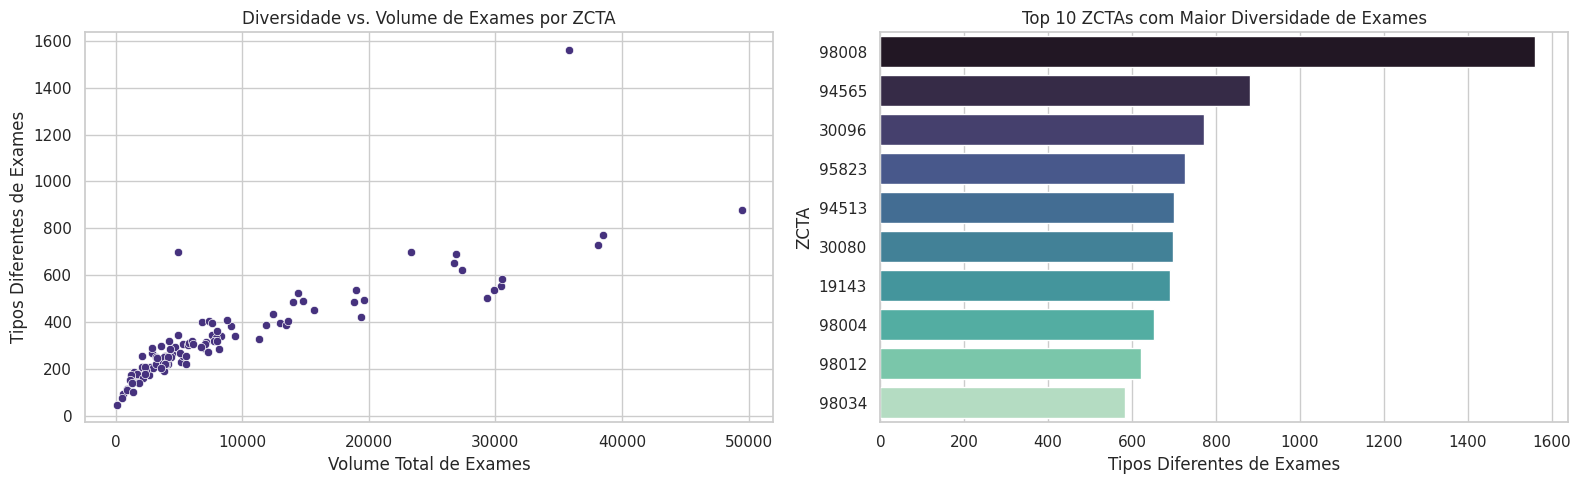

In [4]:
# Garante que a coluna ZCTA existe (através do Lab Id)
dfs['transactional'] = dfs['transactional'].merge(
    dfs['geocode'][['Lab Id', 'Zipcode']],
    on='Lab Id',
    how='left'
)
if 'ZCTA' not in dfs['transactional'].columns:
    dfs['transactional']['ZCTA'] = dfs['transactional']['Zipcode'].astype(str).str.split('.').str[0].str.zfill(5)

# 1. Diversidade de exames por ZCTA
diversidade_exames = (
    dfs['transactional']
    .groupby('ZCTA')['CodItem']
    .nunique()
    .reset_index()
    .rename(columns={'CodItem': 'num_exames_unicos'})
)

# 2. Volume total de exames por ZCTA
volume_exames = (
    dfs['transactional']
    .groupby('ZCTA')
    .size()
    .reset_index(name='num_exames_totais')
)

# 3. Merge para DataFrame final
h5a_df = pd.merge(diversidade_exames, volume_exames, on='ZCTA')
h5a_df['proporcao_diversidade'] = h5a_df['num_exames_unicos'] / h5a_df['num_exames_totais']

# 4. Prepara Top 10 ZCTAs por diversidade
top_diversidade = h5a_df.sort_values(by='num_exames_unicos', ascending=False).head(10)

# 5. Plota os dois gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scatterplot
sns.scatterplot(data=h5a_df, x='num_exames_totais', y='num_exames_unicos', ax=axes[0])
axes[0].set_title('Diversidade vs. Volume de Exames por ZCTA')
axes[0].set_xlabel('Volume Total de Exames')
axes[0].set_ylabel('Tipos Diferentes de Exames')

# Barplot Top 10
sns.barplot(data=top_diversidade, x='num_exames_unicos', y='ZCTA', hue='ZCTA', ax=axes[1], palette='mako')
axes[1].set_title('Top 10 ZCTAs com Maior Diversidade de Exames')
axes[1].set_xlabel('Tipos Diferentes de Exames')
axes[1].set_ylabel('ZCTA')

plt.tight_layout()
plt.show()

### 📊 H5a – Diversidade de Exames como Indicador de Fidelização

A análise da diversidade de exames por ZCTA revela que:

- Existe uma **correlação clara** entre o volume total de exames realizados e a diversidade de tipos distintos de exames.
- ZCTAs como `98008`, `94565`, `30096` e `95823` se destacam não apenas pelo alto volume, mas também por apresentarem **grande variedade de procedimentos**, sugerindo uma **demanda ampla e continuada** dos serviços laboratoriais.
- A presença de muitos tipos diferentes de exames realizados pode indicar que os pacientes retornam para diversas especialidades ou utilizam o laboratório como **único ponto de atendimento**, o que é um **sinal de fidelização**.

> **Conclusão**: A hipótese H5a é **suportada pelos dados** — ZCTAs com maior diversidade de exames tendem a representar regiões com **alto grau de fidelidade dos pacientes**, refletindo maior retenção e engajamento da base de clientes.


In [5]:
paciente_freq = dfs['transactional'].groupby('Patient Id').size().reset_index(name='num_visitas')

# Aplica limite superior (ex: remove top 1%)
limite = paciente_freq['num_visitas'].quantile(0.99)
paciente_freq = paciente_freq[paciente_freq['num_visitas'] <= limite]

paciente_freq

,Patient Id,num_visitas
0,1000007167-1,1
1,1000007439-1,4
2,1000029030-1,1
3,1000031124-1,2
4,1000049179-1,15
...,...,...
200046,99516240-BIO010,8
200047,99585299-BIO002,5
200048,99958237-BIO003,9
200049,99974240-BIO010,9


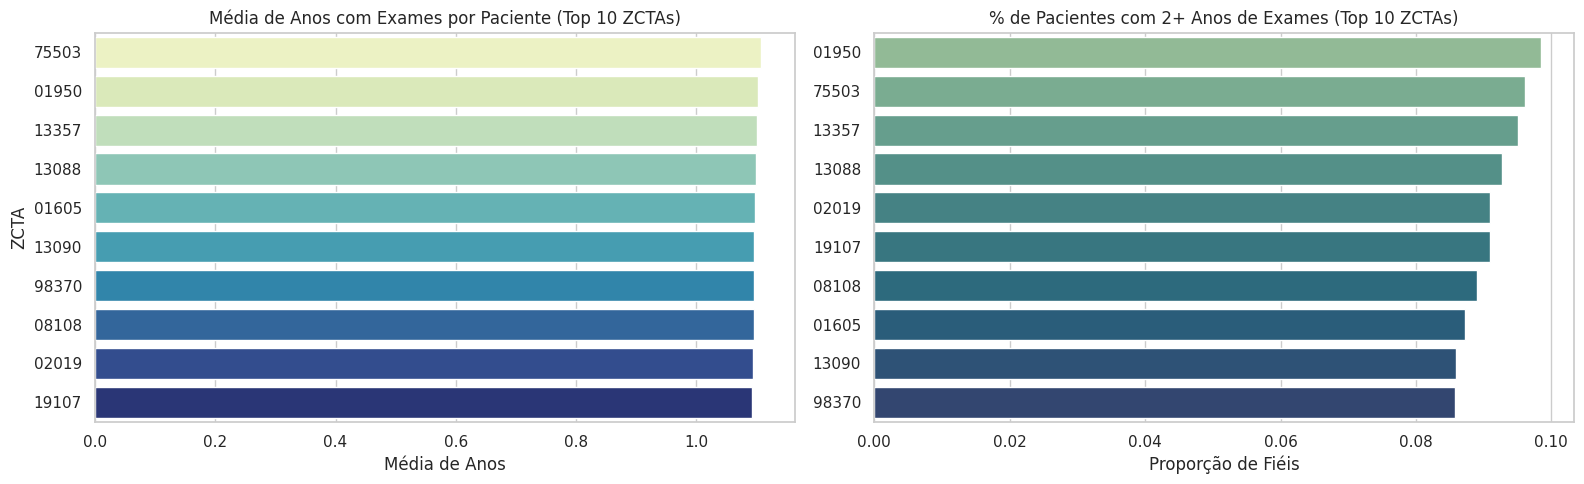

In [9]:
dfs['transactional']['ano'] = dfs['transactional']['Date of service'].dt.year

anos_por_paciente = (
    dfs['transactional']
    .groupby('Patient Id')['ano']
    .nunique()
    .reset_index(name='anos_distintos')
)
zcta_por_paciente = (
    dfs['transactional']
    .groupby(['Patient Id', 'ZCTA'])
    .size()
    .reset_index(name='freq')
    .sort_values(['Patient Id', 'freq'], ascending=[True, False])
    .drop_duplicates('Patient Id')
)

paciente_fidelidade = pd.merge(
    anos_por_paciente, zcta_por_paciente[['Patient Id', 'ZCTA']], on='Patient Id'
)

media_anos = (
    paciente_fidelidade.groupby('ZCTA')['anos_distintos']
    .mean()
    .reset_index(name='media_anos_por_paciente')
)

prop_fieis = (
    paciente_fidelidade.assign(is_fiel=lambda x: x['anos_distintos'] >= 2)
    .groupby('ZCTA')['is_fiel']
    .mean()
    .reset_index(name='proporcao_fieis')
)

fidelidade_zcta = pd.merge(media_anos, prop_fieis, on='ZCTA')
top_fieis = fidelidade_zcta.sort_values(by='media_anos_por_paciente', ascending=False).head(10)
top_fieis2 = fidelidade_zcta.sort_values(by='proporcao_fieis', ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Média de anos por paciente
sns.barplot(data=top_fieis, x='media_anos_por_paciente', y='ZCTA', hue='ZCTA', ax=axes[0], palette='YlGnBu')
axes[0].set_title('Média de Anos com Exames por Paciente (Top 10 ZCTAs)')
axes[0].set_xlabel('Média de Anos')
axes[0].set_ylabel('ZCTA')

# Proporção de pacientes fiéis
sns.barplot(data=top_fieis2, x='proporcao_fieis', y='ZCTA', hue='ZCTA', ax=axes[1], palette='crest')
axes[1].set_title('% de Pacientes com 2+ Anos de Exames (Top 10 ZCTAs)')
axes[1].set_xlabel('Proporção de Fiéis')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## Conclusão – H5b: Recorrência Anual e Fidelização

A análise dos dados indica que a **fidelidade dos pacientes ao longo dos anos é baixa**.

- A **média de anos distintos por paciente** nos principais ZCTAs está próxima de 1.1.
- **Menos de 10%** dos pacientes retornam para exames em anos diferentes.
- Isso sugere que os exames possuem um caráter predominantemente pontual.

No entanto, ZCTAs como `19107` e `02019` se destacam levemente, o que pode indicar **potencial para programas de fidelização** nessas regiões.

> Conclusão: A hipótese H5b **não é suportada fortemente pelos dados atuais**, mas traz insights sobre onde há espaço para melhorar a retenção de pacientes.
